In [1]:
from keyBoost_lib.models.keybert import keybert_extraction

In [2]:
doc = """
         Supervised learning is the machine learning task of learning a function that
         maps an input to an output based on example input-output pairs.[1] It infers a
         function from labeled training data consisting of a set of training examples.[2]
         In supervised learning, each example is a pair consisting of an input object
         (typically a vector) and a desired output value (also called the supervisory signal). 
         A supervised learning algorithm analyzes the training data and produces an inferred function, 
         which can be used for mapping new examples. An optimal scenario will allow for the 
         algorithm to correctly determine the class labels for unseen instances. This requires 
         the learning algorithm to generalize from the training data to unseen situations in a 
         'reasonable' way (see inductive bias).
      """

In [3]:
kb = keybert_extraction(text=doc,
                  keyphrases_ngram_max=2,
                  n_top=100)

In [4]:
from keyBoost_lib.models.yake import yake_extraction

In [5]:
yk = yake_extraction(text=doc,
               language='en',
               keyphrases_ngram_max=2,
               n_top=100)

## Statistical Consensus

In [6]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels.api as sm
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

In [7]:
def freedman_diaconis_rule(data):
    a = np.array(data)
    if len(data) <2:
        return 1
    h = 2*(np.percentile(data,75)-np.percentile(data,25))*len(data)**(-1/3)

    if h==0:
        return len(data)
    else:
        return int(np.ceil((max(data)-min(data))/h))

In [8]:
def DSM_selection(data,
                 distributions,
                 bins):
    
    y, x = np.histogram(a=data,
                       bins=bins,
                       density=True)
    x = (x + np.roll(x,-1))[:-1] / 2.0
    
    # By default, we suppose that the data fits a gaussian model
    
    best_distribution = st.norm
    best_arg,best_loc,best_scale = (None, 0.0, 1.0)
    best_sse = np.inf
    
    for distribution in distributions:
            
        arg, loc, scale = maximum_likelyhood_estimation(data,distribution)

        pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
        sse = np.sum(np.power(y-pdf,2.0))

        if best_sse > sse:
            best_distribution = distribution
            best_arg = arg
            best_loc = loc
            best_scale = scale
            best_sse = sse
       
        
    return best_distribution, best_arg, best_loc, best_scale
        
        
        

In [109]:
def maximum_likelyhood_estimation(data,
                                  distribution):
    
    params = distribution.fit(data)
    
    arg = params[:-2] # distribution parameter vector
    loc = params[-2] # location parameter
    scale = params[-1] # scale parameter 
    
    return arg, loc, scale

In [101]:
def pack_params(arg,loc,scale):
    params = list()
    a = [arg,loc,scale]
    for x in a:
        if type(x)!=tuple:
            params.append(x)
        else:
            for t in x:
                params.append(t)
    return tuple(params)

In [108]:
def kolmogorov_smirnov_test(distribution,
                           data,
                           arg,
                           loc,
                           scale,alpha):
    
    args = pack_params(arg,loc,scale)
    
    _, p_value = st.kstest(rvs=data,
                          cdf=distribution.name,
                          args=args,
                          alternative='two-sided')
    
    
    return True if p_value >= alpha else False # Pass the test if we do not reject H0 : the score distribution is discriminative


In [77]:
def DSM_params_check(distribution,
                     arg):
    
    if distribution == st.powerlaw:
        
        return True if 0<arg[0]<1 else False
    
    elif distribution == st.gamma:
        
        return True if 0<arg[0]<15 else False
    
    elif distribution == st.pareto:
        
        return True
    
    elif distribution == st.powerlognorm:
        
        return True if 0<arg[1]<1 else False

#### Statistical Consensus Workflow


BINS with FD Rule => DSM ( using MLE) => DSM params Check ( if not OK -> RB consensus) => Kolmogorov Test ( if not OK -> RB consensus) => Consolidation ( extract Rank) => Deduplication => top n

In [9]:
from warnings import filterwarnings
filterwarnings('ignore')

In [10]:
discriminative_statistical_models = [st.powerlaw,st.gamma,st.pareto,st.powerlognorm]

In [11]:
optimal_bins = freedman_diaconis_rule(data=yk['Score'])

In [12]:
best_distribution, best_arg, best_loc, best_scale = DSM_selection(data=yk['Score'],
                                  distributions=discriminative_statistical_models,
                                  bins=optimal_bins)

NameError: name 'maximum_likelyhood_estimation' is not defined

In [ ]:
DSM_params_check(best_distribution,best_arg)

In [113]:
kolmogorov_smirnov_test(distribution=best_distribution,
                       data=yk['Score'],
                       arg=best_arg,
                       loc=best_loc,
                       scale=best_scale,
                       alpha=0.05)

True

In [116]:
np.array([False,True]).all()b

False

In [119]:
a = np.array(None)

In [34]:
import seaborn as sns

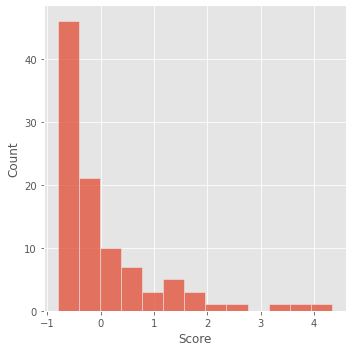

In [35]:
sns.displot(yk['Score'])

In [94]:
pack_params(best_arg,best_loc,best_scale)

[2.777553944546117, -2.317530197125515, 1.5094778258414294]

## Statstical Consensus Pipeline Test

In [6]:
from keyBoost_lib.consensus.statistical import *

In [7]:
statistical_consensus(key_extractions=[yk,kb],
                     n_top=15)

statistical discriminativeness Check
DSM Params OK
KS OK
Proper DSM behind data
Consolidation + Rank Extraction
Deduplication
Done !


[('input-output pairs.', 5.397965638445171),
 ('Supervised learning', 4.6865891469083705),
 ('that maps', 4.505158184034257),
 ('learning algorithm', 4.252988624817484),
 ('machine learning', 3.7072762617093495),
 ('training data', 3.4724274413771337),
 ('algorithm analyzes', 3.3456303271681485),
 ('learning function', 3.3375216739273146),
 ('output based', 2.9051799989546683),
 ('the', 2.8382094734098704),
 ('the algorithm', 2.795052772115514),
 ('labeled training', 2.324749392756941),
 ('learning each', 2.260692523544546),
 ('signal supervised', 2.1877146443770394)]

## Ranking Based Consensus Test

In [8]:
from keyBoost_lib.consensus.ranking import rank_consensus

In [9]:
rank_consensus(key_extractions=[yk,kb],
              n_top=10)

['input-output pairs.',
 'Supervised learning',
 'that maps',
 'training data',
 'learning',
 'learning algorithm',
 'machine learning',
 'supervised learning',
 'algorithm analyzes',
 'learning function']

## keyBoost Global Level Test

In [1]:
from keyBoost_lib.keyBoost import *

In [2]:
doc = """
         Supervised learning is the machine learning task of learning a function that
         maps an input to an output based on example input-output pairs.[1] It infers a
         function from labeled training data consisting of a set of training examples.[2]
         In supervised learning, each example is a pair consisting of an input object
         (typically a vector) and a desired output value (also called the supervisory signal). 
         A supervised learning algorithm analyzes the training data and produces an inferred function, 
         which can be used for mapping new examples. An optimal scenario will allow for the 
         algorithm to correctly determine the class labels for unseen instances. This requires 
         the learning algorithm to generalize from the training data to unseen situations in a 
         'reasonable' way (see inductive bias).
      """

In [3]:
import spacy

nlp = spacy.load('en_core_web_sm')

stopwords = nlp.Defaults.stop_words

In [4]:
keyboost = KeyBoost(transformers_model='distilbert-base-nli-mean-tokens')

In [5]:
keywords = keyboost.extract_keywords(text=doc,
                       language='en',
                       n_top=10,
                       keyphrases_ngram_max=2,
                       stopwords=stopwords,
                       consensus='statistical',
                       models=['keybert','yake','textrank'])

*** statistical discriminativeness check **
* keyword extraction model 1 *
DSM Params OK
KS OK
Proper DSM behind data
* keyword extraction model 2 *
DSM Params OK
KS OK
Proper DSM behind data
* keyword extraction model 3 *
DSM Params OK
KS OK
Proper DSM behind data
[True, True, True]
Consolidation + Rank Extraction
Deduplication
Done !


In [6]:
keywords

[('input-output pairs.', 5.912582853959563),
 ('Supervised learning', 5.1895416302424255),
 ('learning algorithm', 4.335023272355759),
 ('training data', 3.9950915942095175),
 ('machine learning', 3.8497351627521414),
 ('algorithm analyzes', 3.528132641380353),
 ('learning function', 3.5209218225155148),
 ('algorithm generalize', 3.498568284034516),
 ('output based', 3.4588742982091043),
 ('unseen', 3.384234629795115)]

#### textRank module test

In [6]:
from keyBoost_lib.models.textrank import textrank_extraction

In [7]:
tr = textrank_extraction(text=doc,
                   n_top=100)

In [8]:
tr

,Term,Score
0,unseen,1.800759
1,output based,1.775841
2,supervised learning,1.756770
3,input,1.539781
4,example,1.523617
5,examples,1.523617
6,labeled training data consisting,0.434263
7,object,0.279167
8,function,0.090334
9,infers,0.090334


In [9]:
import seaborn as sns

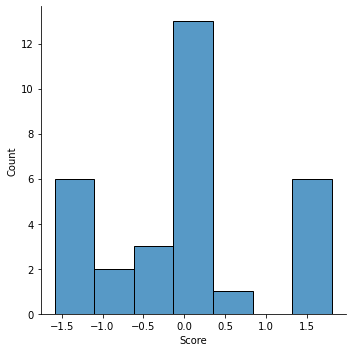

In [10]:
sns.displot(tr['Score'])

In [9]:
from keyBoost_lib.consensus.statistical import *

In [10]:
statistical_consensus(key_extractions=[yk,kb,tr],
                     n_top=15)

statistical discriminativeness Check
[]
DSM Params OK
KS OK
Proper DSM behind data
[True]
DSM Params OK
KS OK
Proper DSM behind data
[True, True]
DSM Params OK
KS OK
Proper DSM behind data
[True, True, True]
Consolidation + Rank Extraction
Deduplication
Done !


[('input-output pairs.', 5.705790561290011),
 ('Supervised learning', 5.01327640071119),
 ('learning algorithm', 4.77083326955788),
 ('machine learning', 4.225120906449745),
 ('training data', 3.8655301235771704),
 ('algorithm analyzes', 3.863474971908544),
 ('learning function', 3.85536631866771),
 ('unseen', 3.384234629795115),
 ('output based', 3.359316989175731),
 ('the algorithm', 3.3128974168559093),
 ('example', 3.1070923751783),
 ('labeled training', 2.8071648486471883),
 ('learning each', 2.7785371682849416),
 ('signal supervised', 2.705559289117435),
 ('for mapping', 2.6106880461996758)]

In [14]:
[kb,tr,yk]

[                   Term     Score
0    learning algorithm  3.187358
1      machine learning  2.641645
2   supervised learning  2.382168
3    algorithm analyzes  2.279999
4     learning function  2.271891
..                  ...       ...
95        situations in -1.024277
96            allow for -1.032386
97      generalize from -1.042927
98              data to -1.049414
99                 pair -1.065631

[100 rows x 2 columns],                                 Term     Score
0                             unseen  1.800759
1                       output based  1.775841
2                supervised learning  1.756770
3                              input  1.539781
4                            example  1.523617
5                           examples  1.523617
6   labeled training data consisting  0.434263
7                             object  0.279167
8                           function  0.090334
9                             infers  0.090334
10                          inferred  0.090334
11